In [1]:
import os
import scanpy as sc
import scipy.io
import scipy.sparse as sp
import pandas as pd 
import numpy as np
import anndata
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def set_directories(patient_id, base_dir):
    """
    Generate a dictionary containing paths to relevant directories for a given patient.
    
    Parameters:
    - patient_id (str): The unique identifier for the patient.
    - base_dir (str): The base directory containing all patient data.
    
    Returns:
    - dict: A dictionary with paths to gene expression, dextramer, TCR, and CITE-seq data.
    """
    return {
        "dir_gex": os.path.join(base_dir, f"{patient_id}/CellRangerGex_results"),
        "dir_dex": os.path.join(base_dir, f"{patient_id}_dextramer_count/umi_count"),
        "dir_TCR": os.path.join(base_dir, f"{patient_id}_TCR_VDJ/CellRangerVdj_results"),
        "dir_CITE": os.path.join(base_dir, f"{patient_id}_CITE/CiteSeq_results/umiCountMatrix")
    }

# Define base directory and patient IDs
base_dir = "/Users/ecrosse/Desktop/"

# Set directories for each patient
dirs_SRSF2_2 = set_directories("november_dextramer_data/WJK-2719_SRSF2_2", base_dir)

# Print to verify the directory structure
print(dirs_SRSF2_2)


{'dir_gex': '/Users/ecrosse/Desktop/november_dextramer_data/WJK-2719_SRSF2_2/CellRangerGex_results', 'dir_dex': '/Users/ecrosse/Desktop/november_dextramer_data/WJK-2719_SRSF2_2_dextramer_count/umi_count', 'dir_TCR': '/Users/ecrosse/Desktop/november_dextramer_data/WJK-2719_SRSF2_2_TCR_VDJ/CellRangerVdj_results', 'dir_CITE': '/Users/ecrosse/Desktop/november_dextramer_data/WJK-2719_SRSF2_2_CITE/CiteSeq_results/umiCountMatrix'}


In [ ]:
# Define paths
dir_gex = dirs_SRSF2_2["dir_gex"]
dir_dex = dirs_SRSF2_2["dir_dex"]
dir_CITE = dirs_SRSF2_2["dir_CITE"]

print(dir_gex)
print(dir_dex)
print(dir_CITE)

adata = sc.read_10x_h5(os.path.join(dir_gex, "filtered_feature_bc_matrix.h5"))
adata.var_names_make_unique()
adata

/Users/ecrosse/Desktop/november_dextramer_data/WJK-2719_SRSF2_2/CellRangerGex_results
/Users/ecrosse/Desktop/november_dextramer_data/WJK-2719_SRSF2_2_dextramer_count/umi_count
/Users/ecrosse/Desktop/november_dextramer_data/WJK-2719_SRSF2_2_CITE/CiteSeq_results/umiCountMatrix


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 8056 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
# Load CITE-seq data
cite_matrix = scipy.io.mmread(f"{dir_CITE}/matrix.mtx.gz").T.tocsr()
cite_barcodes = pd.read_csv(f"{dir_CITE}/barcodes.tsv.gz", header=None, sep='\t')[0].values + "-1"
cite_features = pd.read_csv(f"{dir_CITE}/features.tsv.gz", header=None, sep='\t')[1].values

# Load Dextramer data
dex_matrix = scipy.io.mmread(f"{dir_dex}/matrix.mtx.gz").T.tocsr()
dex_barcodes = pd.read_csv(f"{dir_dex}/barcodes.tsv.gz", header=None, sep='\t')[0].values + "-1"
dex_features = pd.read_csv(f"{dir_dex}/features.tsv.gz", header=None, sep='\t')[1].values

# Find common barcodes across all datasets
common_barcodes = list(set(adata.obs_names) & set(cite_barcodes) & set(dex_barcodes))

# Subset adata to common barcodes
adata = adata[adata.obs_names.isin(common_barcodes)].copy()

# Ensure barcodes are in the same order
cite_indices = np.array([np.where(cite_barcodes == bc)[0][0] for bc in adata.obs_names])
dex_indices = np.array([np.where(dex_barcodes == bc)[0][0] for bc in adata.obs_names])

cite_matrix = cite_matrix[cite_indices, :]
dex_matrix = dex_matrix[dex_indices, :]

# Store multimodal data in .obsm
adata.obsm["CITE"] = cite_matrix
adata.obsm["Dextramer"] = dex_matrix

# Store feature names in .uns
adata.uns["CITE_features"] = cite_features
adata.uns["Dextramer_features"] = dex_features

print("CITE-seq and Dextramer data successfully added to anndata.")



CITE-seq and Dextramer data successfully added to anndata.


In [5]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

print(adata.obs.describe())

       n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt
count        8028.000000   8028.000000      8028.000000    8028.000000
mean         1831.077977   4727.434082        78.575981       2.234771
std           591.329225   2164.642822        54.012627       3.427497
min            77.000000    502.000000         0.000000       0.000000
25%          1548.000000   3772.000000        47.000000       1.051357
50%          1833.000000   4656.500000        67.000000       1.425040
75%          2113.250000   5526.250000        97.000000       2.025842
max          6659.000000  34322.000000      1231.000000      79.987007


In [6]:
sc.pp.filter_cells(adata, min_genes=250)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=500)
# Saving count data
adata.layers["counts"] = adata.X.copy()

# Normalize data (log1p normalization)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Scale the data
sc.pp.scale(adata, max_value=10)  # Scale all genes

In [7]:
# set TCR dir
dir_TCR = dirs_SRSF2_1["dir_TCR"]


# Load V(D)J data
vdj = pd.read_csv(f"{dir_TCR}/filtered_contig_annotations.csv")

# Filtering steps
tcr = vdj[
    (vdj["high_confidence"] == True) & 
    (vdj["chain"].isin(["TRA", "TRB"])) & 
    (vdj["productive"] == True) & 
    (vdj["umis"] >= 3)
][["barcode", "chain", "raw_clonotype_id", 
   "v_gene", "d_gene", "j_gene", "c_gene", 
   "cdr1_nt", "cdr2_nt", "cdr3_nt"]]

# Group by raw_clonotype_id and filter for entries that contain both TRA and TRB chains
tcr = tcr.groupby("raw_clonotype_id").filter(lambda g: any(g["chain"] == "TRA") and any(g["chain"] == "TRB"))

# Reset index if needed
tcr = tcr.reset_index(drop=True)

# Print summary
print(tcr.head())

              barcode chain raw_clonotype_id    v_gene d_gene   j_gene c_gene  \
0  AAACCTGAGGAGTTGC-1   TRA       clonotype7    TRAV39    NaN   TRAJ58   TRAC   
1  AAACCTGAGGAGTTGC-1   TRB       clonotype7     TRBV9    NaN  TRBJ2-7  TRBC2   
2  AAACCTGAGTCAAGGC-1   TRB    clonotype1130   TRBV7-8    NaN  TRBJ2-3  TRBC2   
3  AAACCTGAGTCAAGGC-1   TRA    clonotype1130  TRAV13-1    NaN   TRAJ32   TRAC   
4  AAACCTGCAAGCGAGT-1   TRB      clonotype70   TRBV7-9    NaN  TRBJ1-4  TRBC1   

              cdr1_nt                cdr2_nt  \
0     ACCACTTCAGACAGA  TTGCTATCAAATGGAGCAGTG   
1     TCTGGAGACCTCTCT     TATTATAATGGAGAAGAG   
2     TCGGGTCATGTATCC     TTCCAGAATGAAGCTCAA   
3  GACAGTGCCTCAAACTAC  ATTCGTTCAAATGTGGGCGAA   
4     TCTGAACACAACCGC     TTCCAGAATGAAGCTCAA   

                                             cdr3_nt  
0         TGTGCCGTGGACATTGAAACCAGTGGCTCTAGGTTGACCTTT  
1   TGTGCCAGCAGCCCACTAGGGGGGGCAGGACGTGGCGAGCAGTACTTC  
2  TGTGCCAGCAGCTTAGCTATGACTAGCGGGAGTAGCACAGATACGC...  
3   

In [8]:
# Load clonotype data
clono = pd.read_csv(f"{dir_TCR}/clonotypes.csv")

# Select and rename columns
clono = clono[["clonotype_id", "cdr3s_aa", "cdr3s_nt"]].rename(columns={"clonotype_id": "raw_clonotype_id"})

# Perform a left join with tcr on "raw_clonotype_id"
tcr = tcr.merge(clono, on="raw_clonotype_id", how="left")

# Select barcode and raw_clonotype_id
clonotype_info = tcr[["barcode", "raw_clonotype_id"]].drop_duplicates(subset=["barcode"])

# Set barcode as row index and drop barcode column
clonotype_info = clonotype_info.set_index("barcode")

# Print the resulting dataframe
print(clonotype_info.head())

# Add tcr to metadata
adata.obs = adata.obs.join(clonotype_info, how="left")

# Check if the metadata was added
print(adata.obs.head())


                   raw_clonotype_id
barcode                            
AAACCTGAGGAGTTGC-1       clonotype7
AAACCTGAGTCAAGGC-1    clonotype1130
AAACCTGCAAGCGAGT-1      clonotype70
AAACCTGGTACTCGCG-1      clonotype20
AAACCTGGTAGGACAC-1      clonotype18
                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACCTGAGGAGTTGC-1               2111        5762.0            150.0   
AAACCTGAGTCAAGGC-1               2488        7893.0            124.0   
AAACCTGAGTTACGGG-1               3133       10103.0             71.0   
AAACCTGCAAGCGAGT-1               2553        8941.0            173.0   
AAACCTGGTACTCGCG-1               2131        5486.0             97.0   

                    pct_counts_mt  n_genes  n_counts raw_clonotype_id  
AAACCTGAGGAGTTGC-1       2.603263     2111    5761.0       clonotype7  
AAACCTGAGTCAAGGC-1       1.571012     2488    7890.0    clonotype1130  
AAACCTGAGTTACGGG-1       0.702762     3133   10103.0              NaN  
AAACCTGCAAGCGAGT-1       1.

In [9]:
def clr_transform(matrix, eps=1e-9):
    """Applies CLR transformation to an input matrix (cell-wise), optimized for sparse matrices."""
    if sp.issparse(matrix):
        matrix = matrix.toarray()  # Convert sparse matrix to dense (if memory allows)
    
    gm = np.exp(np.mean(np.log(matrix + eps), axis=1, keepdims=True))  # Geometric mean per cell
    return np.log((matrix + eps) / (gm + eps))  # Standard CLR transformation

# Apply CLR to CITE-seq data
adata.obsm["CITE_clr"] = clr_transform(adata.obsm["CITE"])

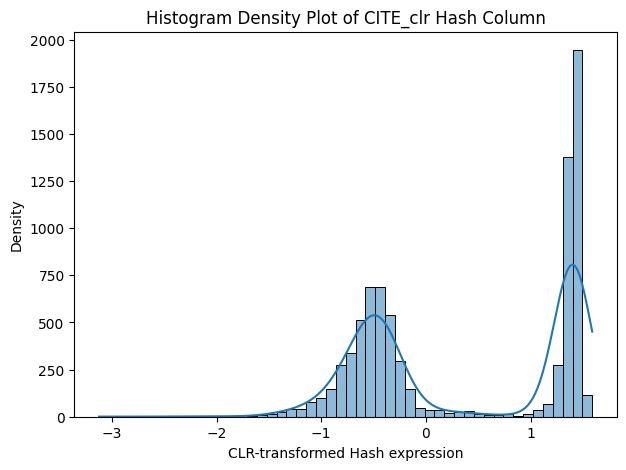

In [10]:
# Identify the index of the "Hash" column
hash_col_index = np.where(adata.uns["CITE_features"] == "Hash")[0][0]

# Extract the Hash column
hash_values = adata.obsm["CITE_clr"][:, hash_col_index]

# Plot density histogram
plt.figure(figsize=(7, 5))
sns.histplot(hash_values, kde=True, bins=50)

plt.xlabel("CLR-transformed Hash expression")
plt.ylabel("Density")
plt.title("Histogram Density Plot of CITE_clr Hash Column")
plt.show()

In [11]:
# Extract the Hash column from CITE_clr
hash_counts = adata.obsm["CITE_clr"][:, hash_col_index]

# Store the extracted counts in adata.obs
adata.obs["HashCounts"] = hash_counts

# Create 'manual_hash_dmux' based on HashCounts threshold
adata.obs["manual_hash_dmux"] = np.where(adata.obs["HashCounts"] > 0.8, "CITE_hash", "Negative")
adata.obs["manual_hash_dmux"].value_counts()


manual_hash_dmux
Negative     4189
CITE_hash    3833
Name: count, dtype: int64

AAACCTGAGGAGTTGC-1    162
AAACCTGAGTCAAGGC-1     74
AAACCTGAGTTACGGG-1     66
AAACCTGCAAGCGAGT-1     63
AAACCTGGTACTCGCG-1     61
Name: Dextramer_total_counts, dtype: int64


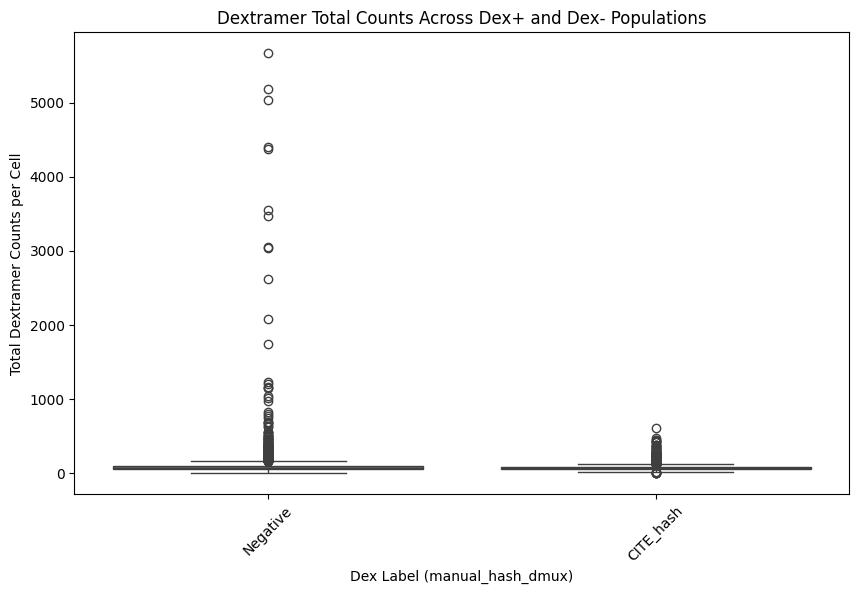

In [12]:
import scipy.sparse as sp

# Identify index of "Unmapped"
unmapped_idx = np.where(adata.uns["Dextramer_features"] == "unmapped")[0][0]

# Remove "Unmapped" from feature list
adata.uns["Dextramer_features"] = np.delete(adata.uns["Dextramer_features"], unmapped_idx)

# Remove "Unmapped" from the Dextramer matrix
adata.obsm["Dextramer"] = sp.csr_matrix(np.delete(adata.obsm["Dextramer"].toarray(), unmapped_idx, axis=1))

# Sum total dextramer counts per cell and store in .obs
adata.obs["Dextramer_total_counts"] = adata.obsm["Dextramer"].sum(axis=1)

# Verify the new column
print(adata.obs["Dextramer_total_counts"].head())

# Create a boxplot of Dextramer total counts grouped by manual_hash_dmux categories
plt.figure(figsize=(10, 6))
sns.boxplot(data=adata.obs, x="manual_hash_dmux", y="Dextramer_total_counts")

# Customize plot labels and title
plt.xlabel("Dex Label (manual_hash_dmux)")
plt.ylabel("Total Dextramer Counts per Cell")
plt.title("Dextramer Total Counts Across Dex+ and Dex- Populations")

# Rotate x-axis labels if necessary for readability
plt.xticks(rotation=45)

plt.show()


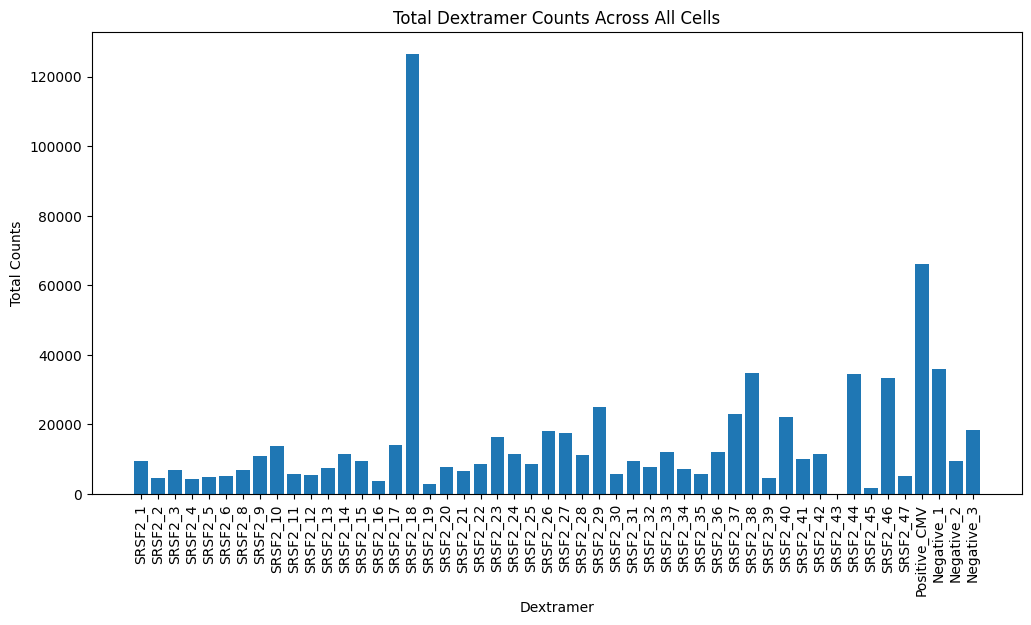

In [13]:
# Sum counts per dextramer across all cells
dextramer_counts = np.array(adata.obsm["Dextramer"].sum(axis=0)).flatten()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(adata.uns["Dextramer_features"], dextramer_counts)
plt.xticks(rotation=90)
plt.xlabel("Dextramer")
plt.ylabel("Total Counts")
plt.title("Total Dextramer Counts Across All Cells")
plt.show()

In [14]:
# Extract dextramer matrix as dense array
dex_matrix = adata.obsm["Dextramer"].toarray()

# Extract Dex+ and Dex- labels
dex_labels = adata.obs["manual_hash_dmux"]

# Identify Dex- cells (assumed to be background)
dex_neg_cells = dex_labels == "CITE_hash"  

# Compute the mean background signal for each dextramer using only Dex- cells
dex_background = dex_matrix[dex_neg_cells].mean(axis=0)  # Mean per dextramer in Dex- cells

# Normalize dextramer signals by their background (Fold-Change Enrichment)
dex_fold_change = dex_matrix / dex_background

# Apply log transformation to reduce extreme values (optional but recommended)
dex_log_fc = np.log1p(dex_fold_change)  # log(1 + x) transformation

# Store the background-normalized dextramer signals back in adata
adata.obsm["Dextramer_norm"] = dex_log_fc

# Print sanity check
print("Shape of normalized dextramer matrix:", adata.obsm["Dextramer_norm"].shape)
print("First few values of a random dextramer after normalization:\n", dex_log_fc[:, 0][:5])

Shape of normalized dextramer matrix: (8022, 50)
First few values of a random dextramer after normalization:
 [1.01753218 0.63296169 1.68933882 0.         0.63296169]


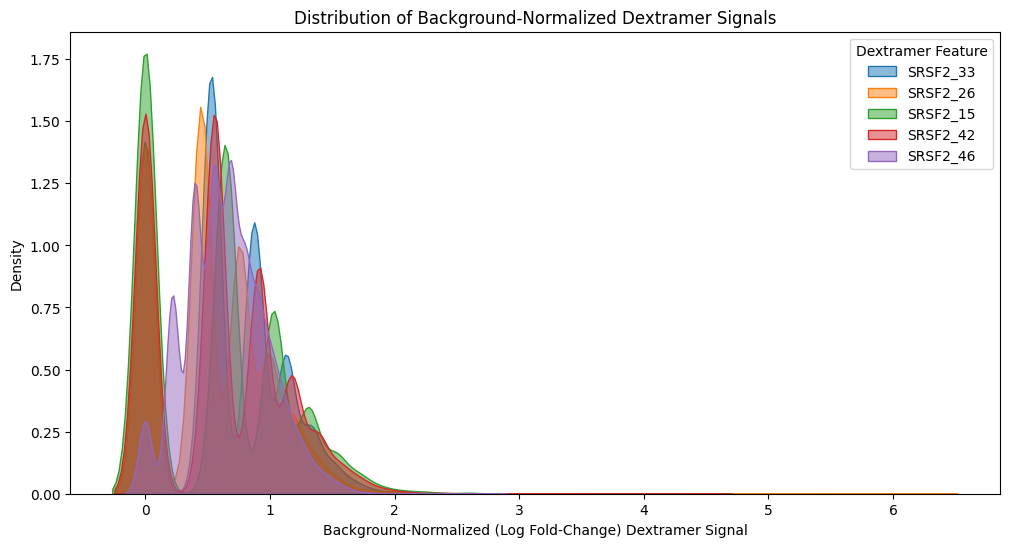

In [15]:
# Select a few dextramers to visualize (randomly choosing 5 for now)
num_features = adata.obsm["Dextramer_norm"].shape[1]
selected_dextramers = np.random.choice(num_features, size=5, replace=False)

# Convert the selected dextramers into a DataFrame for easier plotting
dex_norm_df = pd.DataFrame(adata.obsm["Dextramer_norm"][:, selected_dextramers],
                           columns=[adata.uns["Dextramer_features"][i] for i in selected_dextramers])

# Plot the density distribution of the selected dextramer signals
plt.figure(figsize=(12, 6))
for col in dex_norm_df.columns:
    sns.kdeplot(dex_norm_df[col], label=col, fill=True, alpha=0.5)

plt.xlabel("Background-Normalized (Log Fold-Change) Dextramer Signal")
plt.ylabel("Density")
plt.title("Distribution of Background-Normalized Dextramer Signals")
plt.legend(title="Dextramer Feature")
plt.show()

In [16]:
# Identify Dex+ cells
dex_pos_cells = dex_labels != "CITE_hash" 

# Compute mean dextramer signal across Dex+ cells (per dextramer)
dex_mean_pos = dex_matrix[dex_pos_cells].mean(axis=0)  # Mean per dextramer in Dex+ cells

# Compute relative enrichment: deviation from Dex+ mean (per dextramer, per cell)
dex_enrichment = dex_matrix - dex_mean_pos  # Element-wise subtraction

# Store in adata
adata.obsm["Dextramer_enrichment"] = dex_enrichment

# Print sanity check
print("Shape of Dex+ enrichment matrix:", adata.obsm["Dextramer_enrichment"].shape)
print("First few values of a random dextramer after enrichment calculation:\n", dex_enrichment[:, 0][:5])

Shape of Dex+ enrichment matrix: (8022, 50)
First few values of a random dextramer after enrichment calculation:
 [ 0.77178324 -0.22821676  3.77178324 -1.22821676 -0.22821676]


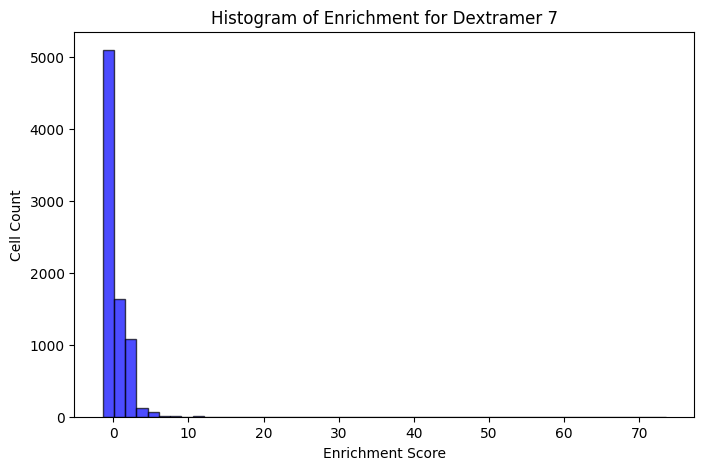

In [17]:
# Select a random dextramer (or a specific one)
dex_idx = 7  # Change this to visualize a different dextramer
dex_values = adata.obsm["Dextramer_enrichment"][:, dex_idx]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(dex_values, bins=50, alpha=0.7, color='b', edgecolor='k')
plt.xlabel("Enrichment Score")
plt.ylabel("Cell Count")
plt.title(f"Histogram of Enrichment for Dextramer {dex_idx}")
plt.show()

In [18]:
# Extract TCR clonotype IDs and Dex+/- labels
clonotypes = adata.obs["raw_clonotype_id"]
dex_labels = adata.obs["manual_hash_dmux"]

# Identify Dex+ and Dex- cells based on corrected labels
dex_pos_mask = dex_labels == "Negative"  # Dex+ group
dex_neg_mask = dex_labels == "CITE_hash"  # Dex- group

# Compute total number of cells in each group
total_dex_pos = np.sum(dex_pos_mask)
total_dex_neg = np.sum(dex_neg_mask)

# Count occurrences of each clonotype in Dex+ and Dex- cells
clonotype_counts = pd.DataFrame({
    "Dex+ Count": clonotypes[dex_pos_mask].value_counts(),
    "Dex- Count": clonotypes[dex_neg_mask].value_counts()
}).fillna(0)


# Compute frequency (proportion) in each group
clonotype_counts["Dex+ Frequency"] = clonotype_counts["Dex+ Count"] / total_dex_pos
clonotype_counts["Dex- Frequency"] = clonotype_counts["Dex- Count"] / total_dex_neg

# Compute fold-change enrichment (log-scaled for better interpretability)
clonotype_counts["Enrichment Ratio"] = clonotype_counts["Dex+ Frequency"] / (clonotype_counts["Dex- Frequency"] + 1e-6)
clonotype_counts["Log Enrichment"] = np.log2(clonotype_counts["Enrichment Ratio"] + 1e-6)


# Store results in adata for later use
adata.uns["clonotype_enrichment"] = clonotype_counts

In [19]:
# Print top TCR clonotypes with highest enrichment
print("Top 10 TCR clonotypes enriched in Dex+ cells:")
print(clonotype_counts.sort_values(by="Dex+ Frequency", ascending=False).head(10))


Top 10 TCR clonotypes enriched in Dex+ cells:
                  Dex+ Count  Dex- Count  Dex+ Frequency  Dex- Frequency  \
raw_clonotype_id                                                           
clonotype1             284.0       312.0        0.067797        0.081398   
clonotype2             239.0       235.0        0.057054        0.061310   
clonotype7             209.0         7.0        0.049893        0.001826   
clonotype3             196.0       221.0        0.046789        0.057657   
clonotype4             171.0       206.0        0.040821        0.053744   
clonotype5             138.0       151.0        0.032943        0.039395   
clonotype6             113.0       128.0        0.026975        0.033394   
clonotype8             108.0        89.0        0.025782        0.023219   
clonotype9              87.0        75.0        0.020769        0.019567   
clonotype11             85.0        69.0        0.020291        0.018002   

                  Enrichment Ratio  Log E

In [20]:
# Use normalized dextramer data
dex_matrix_norm = adata.obsm["Dextramer_norm"]

# Compute ranks within each cell
dextramer_ranks = np.argsort(-dex_matrix_norm, axis=1)  # Descending order
dextramer_rank_values = np.argsort(dextramer_ranks, axis=1) + 1  # Convert to rank (1 = highest)

# Compute competition score
sorted_dex_values = np.sort(dex_matrix_norm, axis=1)[:, ::-1]  # Sort values descending
top_dextramer_signal = sorted_dex_values[:, 0]  # Strongest dextramer per cell
second_strongest_signal = sorted_dex_values[:, 1]  # Second strongest dextramer per cell

top_dextramer_margin = (top_dextramer_signal - second_strongest_signal) / (top_dextramer_signal + 1e-6)

# Store in adata for ML use later
adata.obsm["Dextramer_rank"] = dextramer_rank_values  # Rank matrix per cell/dextramer
adata.obs["Top_dextramer_margin"] = top_dextramer_margin  # One value per cell


In [21]:
# 1️⃣ Extract Cell-Level Features from `obs`
cell_features = adata.obs[["raw_clonotype_id", "Top_dextramer_margin"]].copy()

# Compute clonotype count
clonotype_counts = adata.obs["raw_clonotype_id"].value_counts().to_dict()
cell_features["clonotype_count"] = cell_features["raw_clonotype_id"].map(clonotype_counts)  # ✅ Added clonotype count

# 2️⃣ Extract Dextramer-Level Features from `obsm`
dex_norm_df = pd.DataFrame(adata.obsm["Dextramer_norm"], index=adata.obs_names)
dex_rank_df = pd.DataFrame(adata.obsm["Dextramer_rank"], index=adata.obs_names)
dex_enrich_df = pd.DataFrame(adata.obsm["Dextramer_enrichment"], index=adata.obs_names)  # ✅ Added enrichment

# 3️⃣ Melt the data to create a (cell, dextramer) pair structure
dex_norm_melted = dex_norm_df.reset_index().melt(id_vars="index", var_name="dextramer", value_name="dex_norm")
dex_rank_melted = dex_rank_df.reset_index().melt(id_vars="index", var_name="dextramer", value_name="dex_rank")
dex_enrich_melted = dex_enrich_df.reset_index().melt(id_vars="index", var_name="dextramer", value_name="dex_enrich")  # ✅ Included enrichment

# 4️⃣ Merge all dextramer-related features
dex_features = dex_norm_melted.merge(dex_rank_melted, on=["index", "dextramer"]).merge(dex_enrich_melted, on=["index", "dextramer"])  # ✅ Included enrichment


In [22]:

# 5️⃣ Merge with Cell-Level Features (now includes clonotype count)
X = pd.merge(dex_features, cell_features, left_on="index", right_index=True)

# Rename index for clarity
X.rename(columns={"index": "cell_id"}, inplace=True)
# Fill missing clonotype IDs with "Unknown"
X["raw_clonotype_id"] = X["raw_clonotype_id"].fillna("_no_clonotype_")

# Fill missing clonotype counts with 0
X["clonotype_count"] = X["clonotype_count"].fillna(0)

# Assuming dextramer feature names are stored in adata.var_names
dextramer_names = list(adata.uns["Dextramer_features"])  # This should contain actual dextramer names

# Create mapping from index to name
dex_index_to_name = {i: name for i, name in enumerate(dextramer_names)}

# Print a few mappings to verify
print("Example dextramer mapping:", list(dex_index_to_name.items())[:10])

# Apply mapping
X["dextramer"] = X["dextramer"].map(dex_index_to_name)

Example dextramer mapping: [(0, 'SRSF2_1'), (1, 'SRSF2_2'), (2, 'SRSF2_3'), (3, 'SRSF2_4'), (4, 'SRSF2_5'), (5, 'SRSF2_6'), (6, 'SRSF2_8'), (7, 'SRSF2_9'), (8, 'SRSF2_10'), (9, 'SRSF2_11')]


In [23]:
# Convert stored enrichment DataFrame from adata.uns
clono_enrich_df = adata.uns["clonotype_enrichment"]

# Just keep the 'Log Enrichment' column (or whatever you want)
clono_enrich_df = clono_enrich_df[["Log Enrichment"]]

# Merge into your X DataFrame by raw_clonotype_id
X = X.merge(clono_enrich_df, left_on="raw_clonotype_id", right_index=True, how="left")

# Rename for consistency
X.rename(columns={"Log Enrichment": "clonotype_enrichment"}, inplace=True)

# Fill missing enrichment values with 0
X["clonotype_enrichment"] = X["clonotype_enrichment"].fillna(0)

# Sanity check
print(X[["raw_clonotype_id", "clonotype_enrichment"]].head())

      raw_clonotype_id  clonotype_enrichment
0           clonotype7              4.771083
8022        clonotype7              4.771083
16044       clonotype7              4.771083
24066       clonotype7              4.771083
32088       clonotype7              4.771083


## Isolation forest

In [ ]:
# from sklearn.preprocessing import StandardScaler

# # Select the same feature columns you're using in XGBoost
# feature_cols = ["dex_norm", "dex_rank", "dex_enrich", "Top_dextramer_margin", "clonotype_count", "clonotype_enrichment"]
# X_model = X[feature_cols]

# # Scale the feature matrix for Isolation Forest
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_model)

# from sklearn.ensemble import IsolationForest

# # Define Isolation Forest model
# iso_forest = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)  # 0.1% expected outliers

# # Fit the model on scaled data
# iso_forest.fit(X_scaled)

# # Predict anomaly scores (-1 = outlier, 1 = inlier)
# X["binding_anomaly_score"] = iso_forest.decision_function(X_scaled)  # Higher = more normal, lower = more anomalous
# X["is_likely_binder"] = iso_forest.predict(X_scaled)  # -1 means likely binder, 1 means normal background

# print("Isolation Forest model trained ✅")

# # Group by (dextramer, clonotype)
# X_grouped = X.groupby(["dextramer", "raw_clonotype_id"]).agg(
#     mean_score=("binding_anomaly_score", "mean"),  # Average anomaly score
#     min_score=("binding_anomaly_score", "min"),    # Best anomaly score
#     count=("binding_anomaly_score", "count")       # How often this pair appears
# ).reset_index()

# # Compute a final ranking score (higher weight for best anomaly score, adjusted by count)
# X_grouped["final_score"] = X_grouped["min_score"] * 0.7 + X_grouped["mean_score"] * 0.3

# # Rank by final score (lower = better binder)
# X_ranked = X_grouped.sort_values(by="final_score")

# # Display top predicted unique binding pairs
# print("Top predicted unique neoantigen-TCR binding pairs:\n", X_ranked.head(50))


Isolation Forest model trained ✅
Top predicted unique neoantigen-TCR binding pairs:
           dextramer raw_clonotype_id  mean_score  min_score  count  \
3783       SRSF2_10     clonotype483   -0.081232  -0.081232      1   
2342   Positive_CMV      clonotype39   -0.057976  -0.076925     17   
2178   Positive_CMV     clonotype134   -0.064058  -0.070888      3   
2522   Positive_CMV      clonotype64   -0.056782  -0.069354      8   
15349      SRSF2_26     clonotype450   -0.065092  -0.065092      1   
17612      SRSF2_29     clonotype798   -0.060030  -0.060030      1   
2132   Positive_CMV     clonotype112   -0.054784  -0.059334      3   
2531   Positive_CMV       clonotype7   -0.036443  -0.056768    216   
15261      SRSF2_26     clonotype304   -0.046592  -0.046592      1   
28609      SRSF2_43     clonotype946   -0.045828  -0.045828      1   
3796       SRSF2_10     clonotype542   -0.039488  -0.039488      1   
3610       SRSF2_10     clonotype203    0.008532  -0.060030      2   
3897 

/var/folders/tr/vn7tq20j5757j67mf5gf2xg80000gp/T/ipykernel_52924/314863011.py:16: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/Users/ecrosse/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


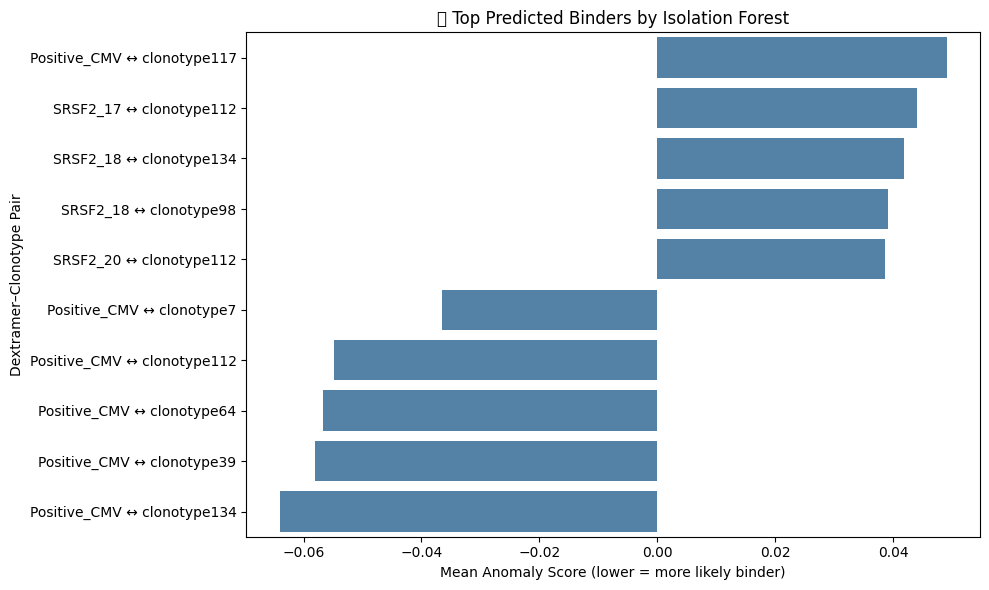

In [ ]:
# # Filter for clonotypes seen in at least 3 cells (optional)
# filtered = X_grouped[X_grouped["count"] >= 3]

# # Sort by mean_score (lower = more anomalous = more likely binder)
# top_pairs = filtered.sort_values("mean_score").head(10)

# # Create a label for plotting
# top_pairs["pair"] = top_pairs["dextramer"] + " ↔ " + top_pairs["raw_clonotype_id"]

# plt.figure(figsize=(10, 6))
# sns.barplot(data=top_pairs, x="mean_score", y="pair", color="steelblue")  # Use a fixed color
# plt.xlabel("Mean Anomaly Score (lower = more likely binder)")
# plt.ylabel("Dextramer–Clonotype Pair")
# plt.title("🔍 Top Predicted Binders by Isolation Forest")
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

In [ ]:
# import joblib
# xgb_model = joblib.load("xgb_binder_model.pkl")

Train the data on positive control

In [24]:
# Define known true binding pairs
known_true_pairs = [
    ("Positive_CMV", "clonotype7"),
    ("Positive_CMV", "clonotype39"),
    ("Positive_CMV", "clonotype64"),
]

# Create ground truth label vector
X["is_true_binder"] = X.apply(
    lambda row: int((row["dextramer"], row["raw_clonotype_id"]) in known_true_pairs),
    axis=1
)

# Confirm label distribution
y = X["is_true_binder"]
print("✅ Label distribution (1 = true binder):")
print(y.value_counts())


✅ Label distribution (1 = true binder):
is_true_binder
0    400859
1       241
Name: count, dtype: int64


In [26]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Define feature columns (same as before)
feature_cols = [
    "dex_norm",
    #"dex_rank",
    "dex_enrich",
    #"Top_dextramer_margin",
    "clonotype_count",
    "clonotype_enrichment"
]

# Build feature matrix and target
X_model = X[feature_cols]
y = X["is_true_binder"]

# Optional: check imbalance
print("Class balance:")
print(y.value_counts())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.2, stratify=y, random_state=42
)

# Set scale_pos_weight = ratio of negatives to positives
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Train classifier
xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

xgb_clf.fit(X_train, y_train)

# Predict
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Evaluate
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=4))



Class balance:
is_true_binder
0    400859
1       241
Name: count, dtype: int64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:50:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     80172
           1     0.9412    1.0000    0.9697        48

    accuracy                         1.0000     80220
   macro avg     0.9706    1.0000    0.9848     80220
weighted avg     1.0000    1.0000    1.0000     80220



In [29]:
import joblib

# Save the trained classifier to a file
joblib.dump(xgb_clf, "xgb_cmv_binder_classifier.pkl")


['xgb_cmv_binder_classifier.pkl']